In [19]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
pixels = 784 # 28x28
hidden_size_1 = 256
hidden_size_2 = 256
digits = 10
nepochs = 10
batch_size = 100
l_r = 0.01

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# testcases = iter(test_loader)
# testcase_x, testcase_y = testcases.next()



In [20]:
# Fully connected neural network with 2 hidden layers
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(NeuralNet, self).__init__()

        self.relu = nn.ReLU()
        self.l1 = nn.Linear(input_size, hidden_size_1)
        self.l2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.l3 = nn.Linear(hidden_size_2, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        # no activation at the end
        return out

model = NeuralNet(pixels, hidden_size_1, hidden_size_2, digits).to(device)

# Loss and optimizer setting
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=l_r, momentum=0.9)

loss_table=[]
accuracy_table=[]


In [21]:
# Setting model to evaluation mode (no gradient updates)
model.eval()

# Computing initial training loss
initial_train_loss = 0.0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        initial_train_loss += loss.item()

initial_train_loss /= len(train_loader)  # Average loss
loss_table.append(initial_train_loss)
print(f"Initial Training Loss (0th iteration): {initial_train_loss:.4f}")

# Compute initial test accuracy
initial_correct = 0
initial_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        initial_total += labels.size(0)
        initial_correct += (predicted == labels).sum().item()

initial_accuracy = initial_correct / initial_total
accuracy_table.append(initial_accuracy * 100)
print(f"Initial Test Accuracy (0th iteration): {initial_accuracy * 100:.2f}%")

Initial Training Loss (0th iteration): 2.3028
Initial Test Accuracy (0th iteration): 10.09%


In [22]:
# Training the model
total_steps = len(train_loader)
for epoch in range(nepochs):
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass and loss calculation
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize, set gradient to zero
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss_table.append(loss.item())
    print (f'Epoch [{epoch+1}/{nepochs}], Loss: {loss.item():.4f}')


    # Test the model: we should stop computing gradients
    with torch.no_grad():
        n_correct = 0
        n_samples = len(test_loader.dataset)

        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = model(images)

            # max returns (output_value ,index)
            maximum, predicted = torch.max(outputs, 1)
            n_correct += (predicted == labels).sum().item()

        acc = n_correct / n_samples
        accuracy_table.append(acc * 100)
        print(f'Epoch [{epoch+1}/{nepochs}], Test Accuracy of the network on the {n_samples} test images: {100*acc} %')

        n_correct=0


Epoch [1/10], Loss: 0.3867
Epoch [1/10], Test Accuracy of the network on the 10000 test images: 92.45 %
Epoch [2/10], Loss: 0.1522
Epoch [2/10], Test Accuracy of the network on the 10000 test images: 94.44 %
Epoch [3/10], Loss: 0.1763
Epoch [3/10], Test Accuracy of the network on the 10000 test images: 95.73 %
Epoch [4/10], Loss: 0.0744
Epoch [4/10], Test Accuracy of the network on the 10000 test images: 96.49 %
Epoch [5/10], Loss: 0.3238
Epoch [5/10], Test Accuracy of the network on the 10000 test images: 96.87 %
Epoch [6/10], Loss: 0.1291
Epoch [6/10], Test Accuracy of the network on the 10000 test images: 97.11 %
Epoch [7/10], Loss: 0.1150
Epoch [7/10], Test Accuracy of the network on the 10000 test images: 97.24000000000001 %
Epoch [8/10], Loss: 0.0672
Epoch [8/10], Test Accuracy of the network on the 10000 test images: 97.47 %
Epoch [9/10], Loss: 0.0329
Epoch [9/10], Test Accuracy of the network on the 10000 test images: 97.56 %
Epoch [10/10], Loss: 0.0277
Epoch [10/10], Test Accu

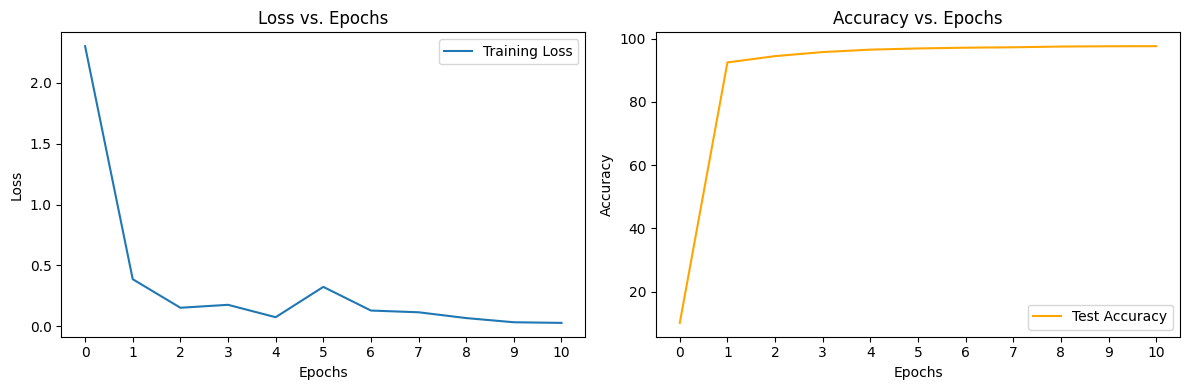

In [25]:
# To Visualize training progress using plots (e.g., loss vs. epochs, accuracy vs. epochs).

# Plot Loss vs. Epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(nepochs+1), loss_table, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.xticks(range(0, 11, 1))
plt.legend()

# Plot Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.plot(range(nepochs+1), accuracy_table, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xticks(range(0, 11, 1))
plt.legend()

plt.tight_layout()
plt.show()
